In [0]:

# PySpark SQL Lab: Udemy Courses Dataset Analysis
# Databricks Notebook - Serverless Compute Compatible

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import json


In [0]:
# Load the dataset
df = spark.table("workspace.default.udemy_courses")
df.createOrReplaceTempView("udemy_courses")

print(f"Dataset loaded: {df.count():,} records, {len(df.columns)} columns")

Dataset loaded: 3,683 records, 13 columns


Creating visualization: Course Distribution by Subject


/home/spark-153e841a-aee8-4fa3-8e3d-61/.ipykernel/2493/command-5223234511290438-1701315122:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subject_dist_pd, x='course_count', y='subject', palette='viridis')


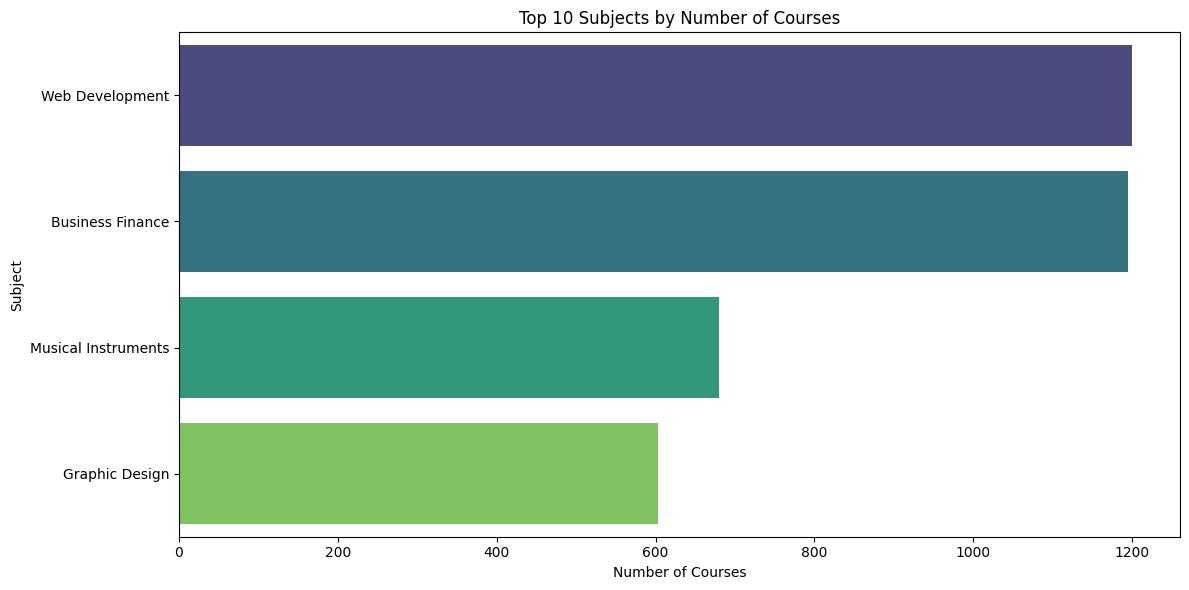

Top 10 subjects by course count:
+-------------------+------------+---------+---------------+
|subject            |course_count|avg_price|avg_subscribers|
+-------------------+------------+---------+---------------+
|Web Development    |1200        |77.03    |6650.0         |
|Business Finance   |1195        |68.55    |1564.0         |
|Musical Instruments|680         |49.56    |1245.0         |
|Graphic Design     |603         |57.83    |1763.0         |
+-------------------+------------+---------+---------------+



In [0]:
# =============================================================================
# VISUALIZATION 1: Course Distribution by Subject (Top 10)
# =============================================================================

print("Creating visualization: Course Distribution by Subject")

subject_dist = spark.sql("""
    SELECT 
        subject,
        COUNT(*) as course_count,
        ROUND(AVG(price), 2) as avg_price,
        ROUND(AVG(num_subscribers), 0) as avg_subscribers
    FROM udemy_courses
    WHERE subject IS NOT NULL
    GROUP BY subject
    ORDER BY course_count DESC
    LIMIT 10
""")

# Convert to Pandas for visualization
subject_dist_pd = subject_dist.toPandas()

# Display the chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=subject_dist_pd, x='course_count', y='subject', palette='viridis')
plt.title('Top 10 Subjects by Number of Courses')
plt.xlabel('Number of Courses')
plt.ylabel('Subject')
plt.tight_layout()
plt.show()

print("Top 10 subjects by course count:")
subject_dist.show(truncate=False)



Creating visualization: Price Distribution Analysis


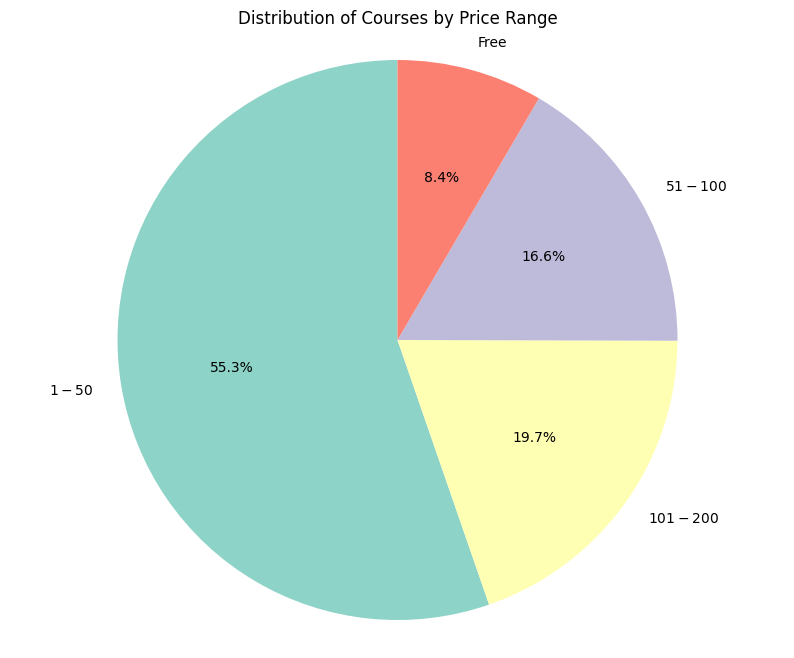

Price distribution analysis:
+-----------+------------+---------------+-----------+
|price_range|course_count|avg_subscribers|avg_reviews|
+-----------+------------+---------------+-----------+
|     $1-$50|        2034|         1431.0|       42.0|
|  $101-$200|         723|         5008.0|      411.0|
|   $51-$100|         611|         2704.0|       98.0|
|       Free|         310|        11534.0|      426.0|
+-----------+------------+---------------+-----------+



In [0]:
# =============================================================================
# VISUALIZATION 2: Price Distribution Analysis
# =============================================================================

print("\nCreating visualization: Price Distribution Analysis")

price_dist = spark.sql("""
    SELECT 
        CASE 
            WHEN price = 0 THEN 'Free'
            WHEN price > 0 AND price <= 50 THEN '$1-$50'
            WHEN price > 50 AND price <= 100 THEN '$51-$100'
            WHEN price > 100 AND price <= 200 THEN '$101-$200'
            WHEN price > 200 THEN 'Above $200'
        END as price_range,
        COUNT(*) as course_count,
        ROUND(AVG(num_subscribers), 0) as avg_subscribers,
        ROUND(AVG(num_reviews), 0) as avg_reviews
    FROM udemy_courses
    WHERE price IS NOT NULL
    GROUP BY 
        CASE 
            WHEN price = 0 THEN 'Free'
            WHEN price > 0 AND price <= 50 THEN '$1-$50'
            WHEN price > 50 AND price <= 100 THEN '$51-$100'
            WHEN price > 100 AND price <= 200 THEN '$101-$200'
            WHEN price > 200 THEN 'Above $200'
        END
    ORDER BY course_count DESC
""")

price_dist_pd = price_dist.toPandas()

# Create price distribution pie chart
plt.figure(figsize=(10, 8))
plt.pie(price_dist_pd['course_count'], labels=price_dist_pd['price_range'], 
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set3'))
plt.title('Distribution of Courses by Price Range')
plt.axis('equal')
plt.show()

print("Price distribution analysis:")
price_dist.show()


Creating visualization: Paid vs Free Course Performance


/home/spark-153e841a-aee8-4fa3-8e3d-61/.ipykernel/2493/command-5223234511290441-3152655791:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=paid_free_pd, x='course_type', y='course_count', ax=ax1, palette='Set1')
/home/spark-153e841a-aee8-4fa3-8e3d-61/.ipykernel/2493/command-5223234511290441-3152655791:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=paid_free_pd, x='course_type', y='avg_subscribers', ax=ax2, palette='Set1')
/home/spark-153e841a-aee8-4fa3-8e3d-61/.ipykernel/2493/command-5223234511290441-3152655791:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` f

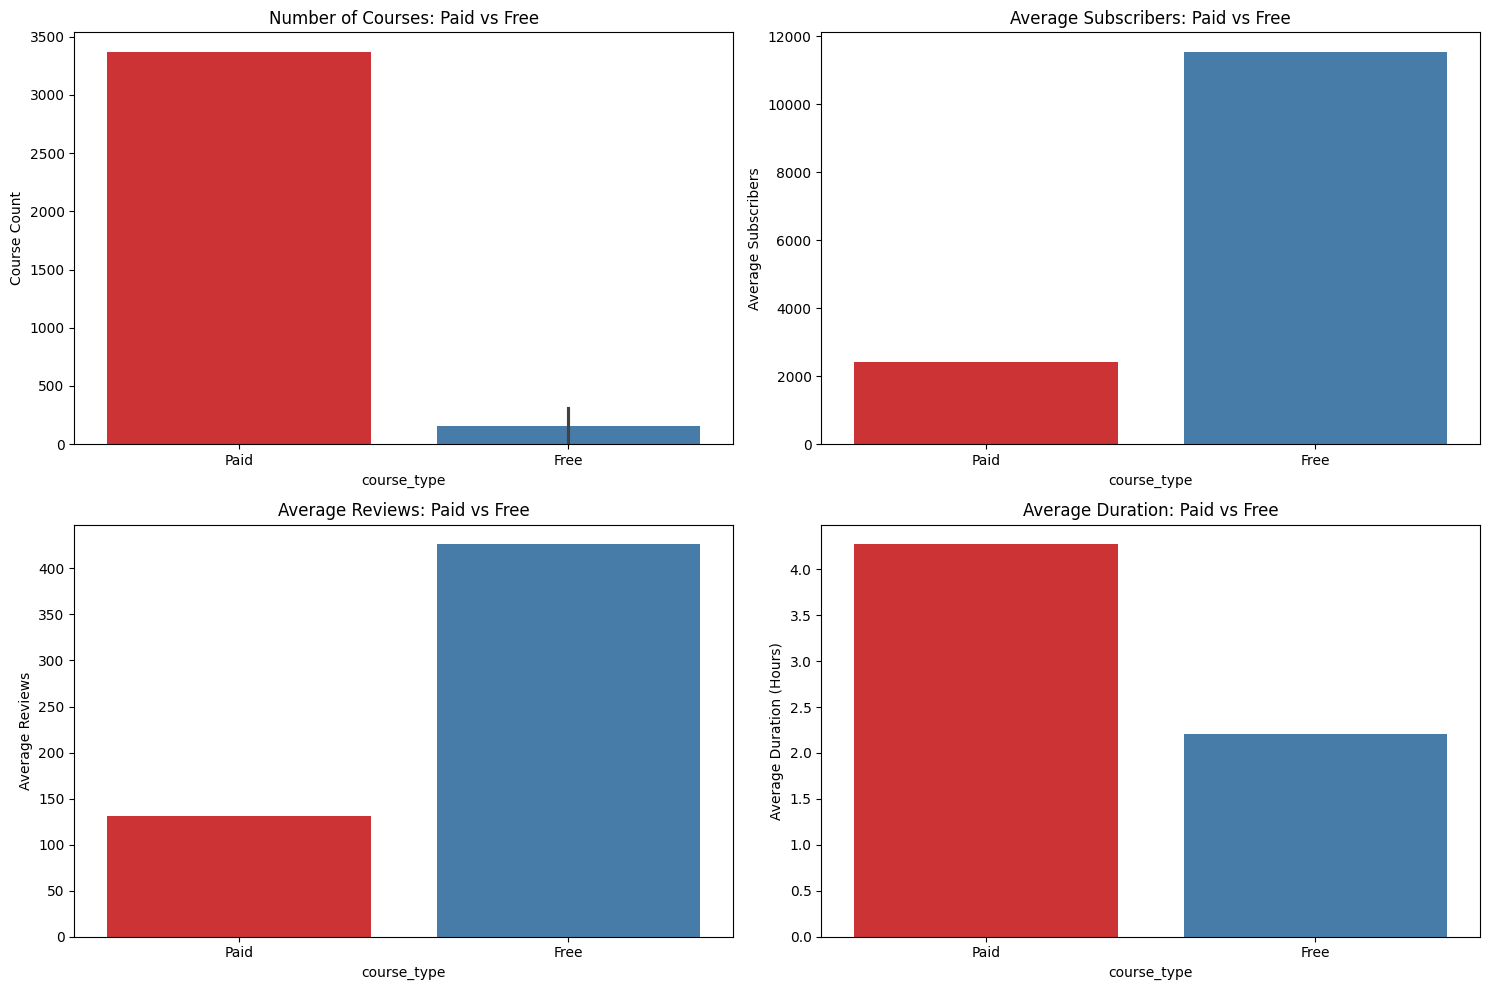

Paid vs Free course analysis:
+-----------+------------+---------+---------------+-----------+------------------+
|course_type|course_count|avg_price|avg_subscribers|avg_reviews|avg_duration_hours|
+-----------+------------+---------+---------------+-----------+------------------+
|       Paid|        3368|    72.13|         2430.0|      131.0|              4.27|
|       Free|         310|      0.0|        11534.0|      426.0|              2.21|
|       Free|           5|      0.0|           NULL|       NULL|              NULL|
+-----------+------------+---------+---------------+-----------+------------------+



In [0]:
# =============================================================================
# VISUALIZATION 3: Paid vs Free Courses Performance
# =============================================================================

print("\nCreating visualization: Paid vs Free Course Performance")

paid_free = spark.sql("""
    SELECT 
        CASE WHEN is_paid THEN 'Paid' ELSE 'Free' END as course_type,
        COUNT(*) as course_count,
        ROUND(AVG(CASE WHEN is_paid THEN price ELSE 0 END), 2) as avg_price,
        ROUND(AVG(num_subscribers), 0) as avg_subscribers,
        ROUND(AVG(num_reviews), 0) as avg_reviews,
        ROUND(AVG(content_duration), 2) as avg_duration_hours
    FROM udemy_courses
    GROUP BY is_paid
""")

paid_free_pd = paid_free.toPandas()

# Create comparison charts
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Course count comparison
sns.barplot(data=paid_free_pd, x='course_type', y='course_count', ax=ax1, palette='Set1')
ax1.set_title('Number of Courses: Paid vs Free')
ax1.set_ylabel('Course Count')

# Average subscribers comparison
sns.barplot(data=paid_free_pd, x='course_type', y='avg_subscribers', ax=ax2, palette='Set1')
ax2.set_title('Average Subscribers: Paid vs Free')
ax2.set_ylabel('Average Subscribers')

# Average reviews comparison
sns.barplot(data=paid_free_pd, x='course_type', y='avg_reviews', ax=ax3, palette='Set1')
ax3.set_title('Average Reviews: Paid vs Free')
ax3.set_ylabel('Average Reviews')

# Average duration comparison
sns.barplot(data=paid_free_pd, x='course_type', y='avg_duration_hours', ax=ax4, palette='Set1')
ax4.set_title('Average Duration: Paid vs Free')
ax4.set_ylabel('Average Duration (Hours)')

plt.tight_layout()
plt.show()

print("Paid vs Free course analysis:")
paid_free.show()


Creating visualization: Course Level Analysis


/home/spark-153e841a-aee8-4fa3-8e3d-61/.ipykernel/2493/command-5223234511290442-329726880:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=level_pd, x='level', y='course_count', ax=ax1, palette='viridis')
/home/spark-153e841a-aee8-4fa3-8e3d-61/.ipykernel/2493/command-5223234511290442-329726880:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=level_pd, x='level', y='avg_price', ax=ax2, palette='viridis')
/home/spark-153e841a-aee8-4fa3-8e3d-61/.ipykernel/2493/command-5223234511290442-329726880:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  

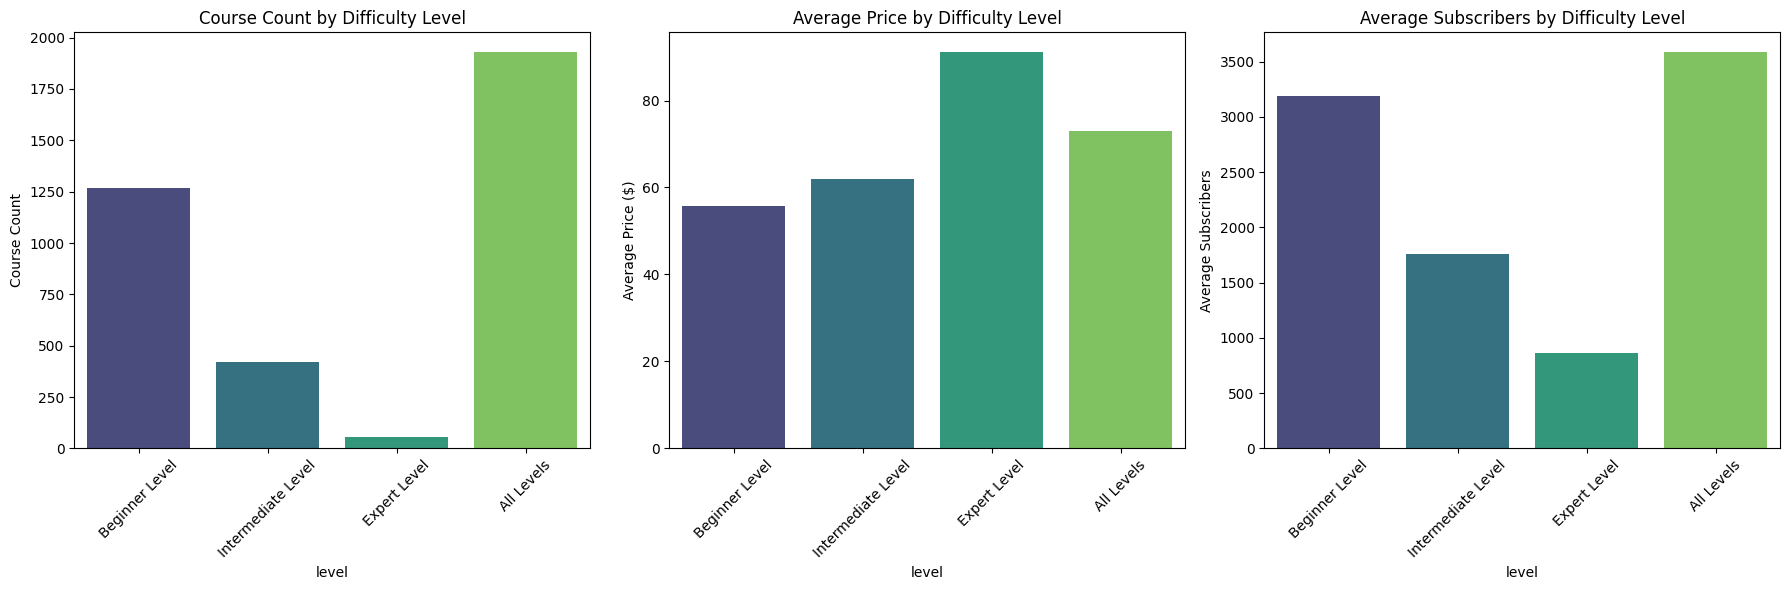

Course level analysis:
+------------------+------------+---------+---------------+-----------+------------------+
|             level|course_count|avg_price|avg_subscribers|avg_reviews|avg_duration_hours|
+------------------+------------+---------+---------------+-----------+------------------+
|    Beginner Level|        1270|    55.68|         3190.0|      102.0|              3.09|
|Intermediate Level|         421|    61.92|         1762.0|       93.0|              3.73|
|      Expert Level|          58|    91.12|          865.0|       40.0|              2.91|
|        All Levels|        1929|    73.02|         3585.0|      210.0|              4.87|
+------------------+------------+---------+---------------+-----------+------------------+



In [0]:
# =============================================================================
# VISUALIZATION 4: Course Level Distribution and Performance
# =============================================================================

print("\nCreating visualization: Course Level Analysis")

level_analysis = spark.sql("""
    SELECT 
        level,
        COUNT(*) as course_count,
        ROUND(AVG(price), 2) as avg_price,
        ROUND(AVG(num_subscribers), 0) as avg_subscribers,
        ROUND(AVG(num_reviews), 0) as avg_reviews,
        ROUND(AVG(content_duration), 2) as avg_duration_hours
    FROM udemy_courses
    WHERE level IS NOT NULL
    GROUP BY level
    ORDER BY 
        CASE 
            WHEN level = 'Beginner Level' THEN 1
            WHEN level = 'Intermediate Level' THEN 2
            WHEN level = 'Expert Level' THEN 3
            ELSE 4
        END
""")

level_pd = level_analysis.toPandas()

# Create level analysis visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Course count by level
sns.barplot(data=level_pd, x='level', y='course_count', ax=ax1, palette='viridis')
ax1.set_title('Course Count by Difficulty Level')
ax1.set_ylabel('Course Count')
ax1.tick_params(axis='x', rotation=45)

# Average price by level
sns.barplot(data=level_pd, x='level', y='avg_price', ax=ax2, palette='viridis')
ax2.set_title('Average Price by Difficulty Level')
ax2.set_ylabel('Average Price ($)')
ax2.tick_params(axis='x', rotation=45)

# Average subscribers by level
sns.barplot(data=level_pd, x='level', y='avg_subscribers', ax=ax3, palette='viridis')
ax3.set_title('Average Subscribers by Difficulty Level')
ax3.set_ylabel('Average Subscribers')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Course level analysis:")
level_analysis.show()


Creating visualization: Top Performing Courses
Top 15 performing courses (50K+ subscribers, 5K+ reviews):
+------------------------------------------------------------+-------------------+---------------+-----------+-----+---------------+----------------+
|course_title                                                |subject            |num_subscribers|num_reviews|price|engagement_rate|content_duration|
+------------------------------------------------------------+-------------------+---------------+-----------+-----+---------------+----------------+
|Learn HTML5 Programming From Scratch                        |Web Development    |268923         |8629       |0    |3.21           |10.5            |
|The Web Developer Bootcamp                                  |Web Development    |121584         |27445      |200  |22.57          |43.0            |
|Build Your First Website in 1 Week with HTML5 and CSS3      |Web Development    |120291         |5924       |0    |4.92           |3.0        

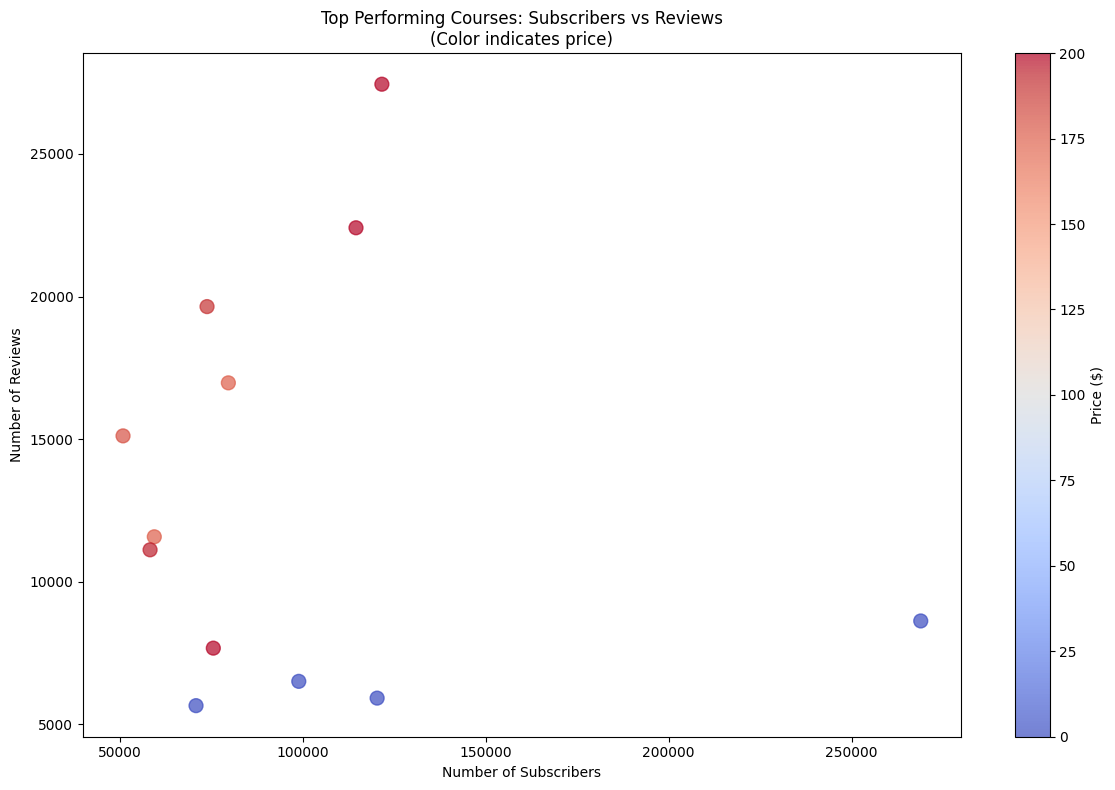

In [0]:
# =============================================================================
# VISUALIZATION 5: Top Performing Courses Analysis
# =============================================================================

print("\nCreating visualization: Top Performing Courses")

top_courses = spark.sql("""
    SELECT 
        course_title,
        subject,
        num_subscribers,
        num_reviews,
        price,
        ROUND(num_reviews * 100.0 / NULLIF(num_subscribers, 0), 2) as engagement_rate,
        content_duration
    FROM udemy_courses
    WHERE num_subscribers >= 50000 
        AND num_reviews >= 5000
        AND num_subscribers IS NOT NULL
        AND num_reviews IS NOT NULL
    ORDER BY num_subscribers DESC
    LIMIT 15
""")

print("Top 15 performing courses (50K+ subscribers, 5K+ reviews):")
top_courses.show(truncate=False)

top_courses_pd = top_courses.toPandas()

if len(top_courses_pd) > 0:
    # Create scatter plot of subscribers vs reviews
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(top_courses_pd['num_subscribers'], 
                         top_courses_pd['num_reviews'],
                         c=top_courses_pd['price'], 
                         s=100, 
                         alpha=0.7,
                         cmap='coolwarm')
    plt.colorbar(scatter, label='Price ($)')
    plt.xlabel('Number of Subscribers')
    plt.ylabel('Number of Reviews')
    plt.title('Top Performing Courses: Subscribers vs Reviews\n(Color indicates price)')
    plt.tight_layout()
    plt.show()



Creating visualization: Subject Performance Matrix


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff1dd6d19d00>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


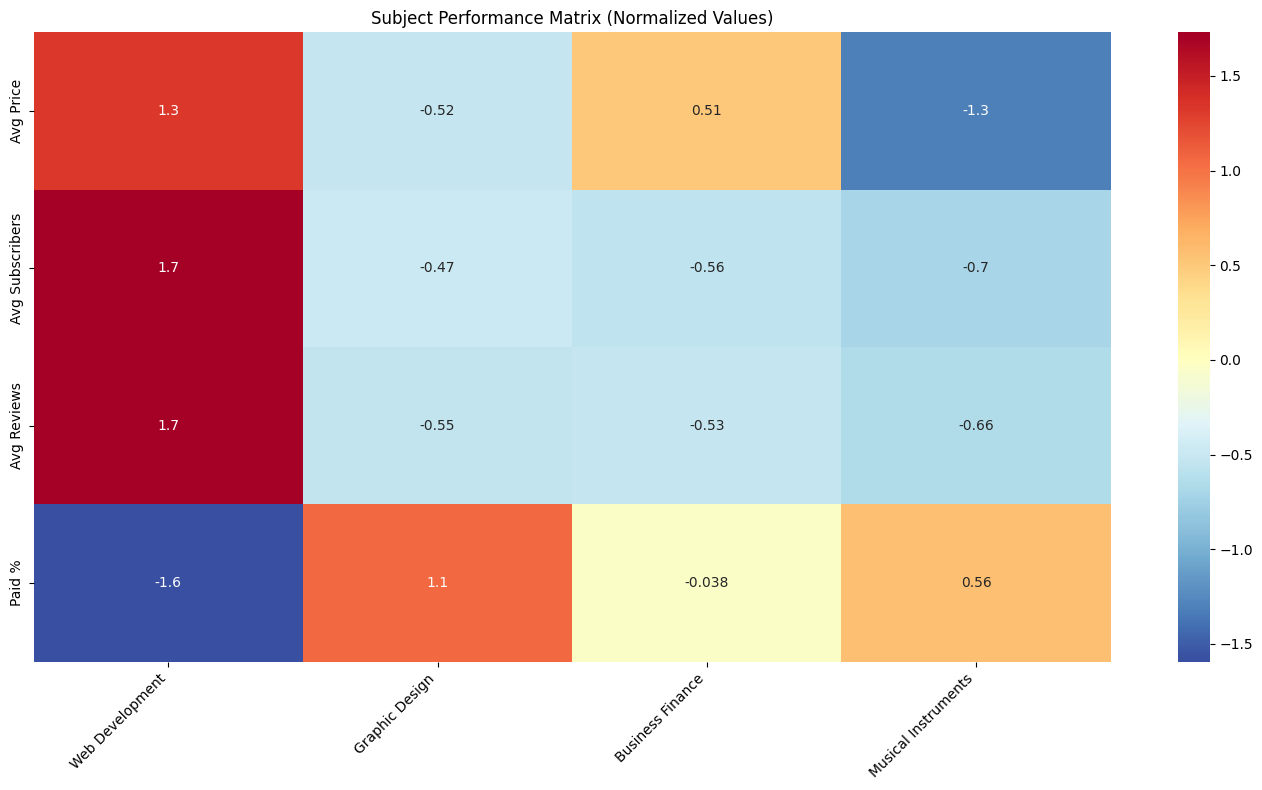

Subject performance matrix:
+-------------------+-------------+---------+---------------+-----------+---------------+------------+
|subject            |total_courses|avg_price|avg_subscribers|avg_reviews|paid_percentage|avg_duration|
+-------------------+-------------+---------+---------------+-----------+---------------+------------+
|Web Development    |1200         |77.03    |6650.0         |358.0      |88.9           |5.59        |
|Graphic Design     |603          |57.83    |1763.0         |61.0       |94.2           |3.58        |
|Business Finance   |1195         |68.55    |1564.0         |64.0       |92.0           |3.55        |
|Musical Instruments|680          |49.56    |1245.0         |47.0       |93.2           |2.85        |
+-------------------+-------------+---------+---------------+-----------+---------------+------------+



In [0]:
# =============================================================================
# VISUALIZATION 6: Subject Performance Matrix
# =============================================================================

print("\nCreating visualization: Subject Performance Matrix")

subject_matrix = spark.sql("""
    SELECT 
        subject,
        COUNT(*) as total_courses,
        ROUND(AVG(price), 2) as avg_price,
        ROUND(AVG(num_subscribers), 0) as avg_subscribers,
        ROUND(AVG(num_reviews), 0) as avg_reviews,
        ROUND(SUM(CASE WHEN is_paid = true THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) as paid_percentage,
        ROUND(AVG(content_duration), 2) as avg_duration
    FROM udemy_courses
    WHERE subject IS NOT NULL
    GROUP BY subject
    HAVING COUNT(*) >= 100
    ORDER BY avg_subscribers DESC
    LIMIT 10
""")

matrix_pd = subject_matrix.toPandas()

# Create heatmap-style visualization
plt.figure(figsize=(14, 8))
metrics_df = matrix_pd.set_index('subject')[['avg_price', 'avg_subscribers', 'avg_reviews', 'paid_percentage']]

# Normalize the data for better heatmap visualization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
metrics_normalized = scaler.fit_transform(metrics_df)

sns.heatmap(metrics_normalized.T, 
            xticklabels=metrics_df.index,
            yticklabels=['Avg Price', 'Avg Subscribers', 'Avg Reviews', 'Paid %'],
            annot=True, 
            cmap='RdYlBu_r',
            center=0)
plt.title('Subject Performance Matrix (Normalized Values)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Subject performance matrix:")
subject_matrix.show(truncate=False)


Creating visualization: Content Duration vs Engagement


/home/spark-153e841a-aee8-4fa3-8e3d-61/.ipykernel/2493/command-5223234511290445-422581333:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=duration_pd, x='duration_range', y='course_count', ax=ax1, palette='plasma')
/home/spark-153e841a-aee8-4fa3-8e3d-61/.ipykernel/2493/command-5223234511290445-422581333:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=duration_pd, x='duration_range', y='avg_subscribers', ax=ax2, palette='plasma')
/home/spark-153e841a-aee8-4fa3-8e3d-61/.ipykernel/2493/command-5223234511290445-422581333:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=Fal

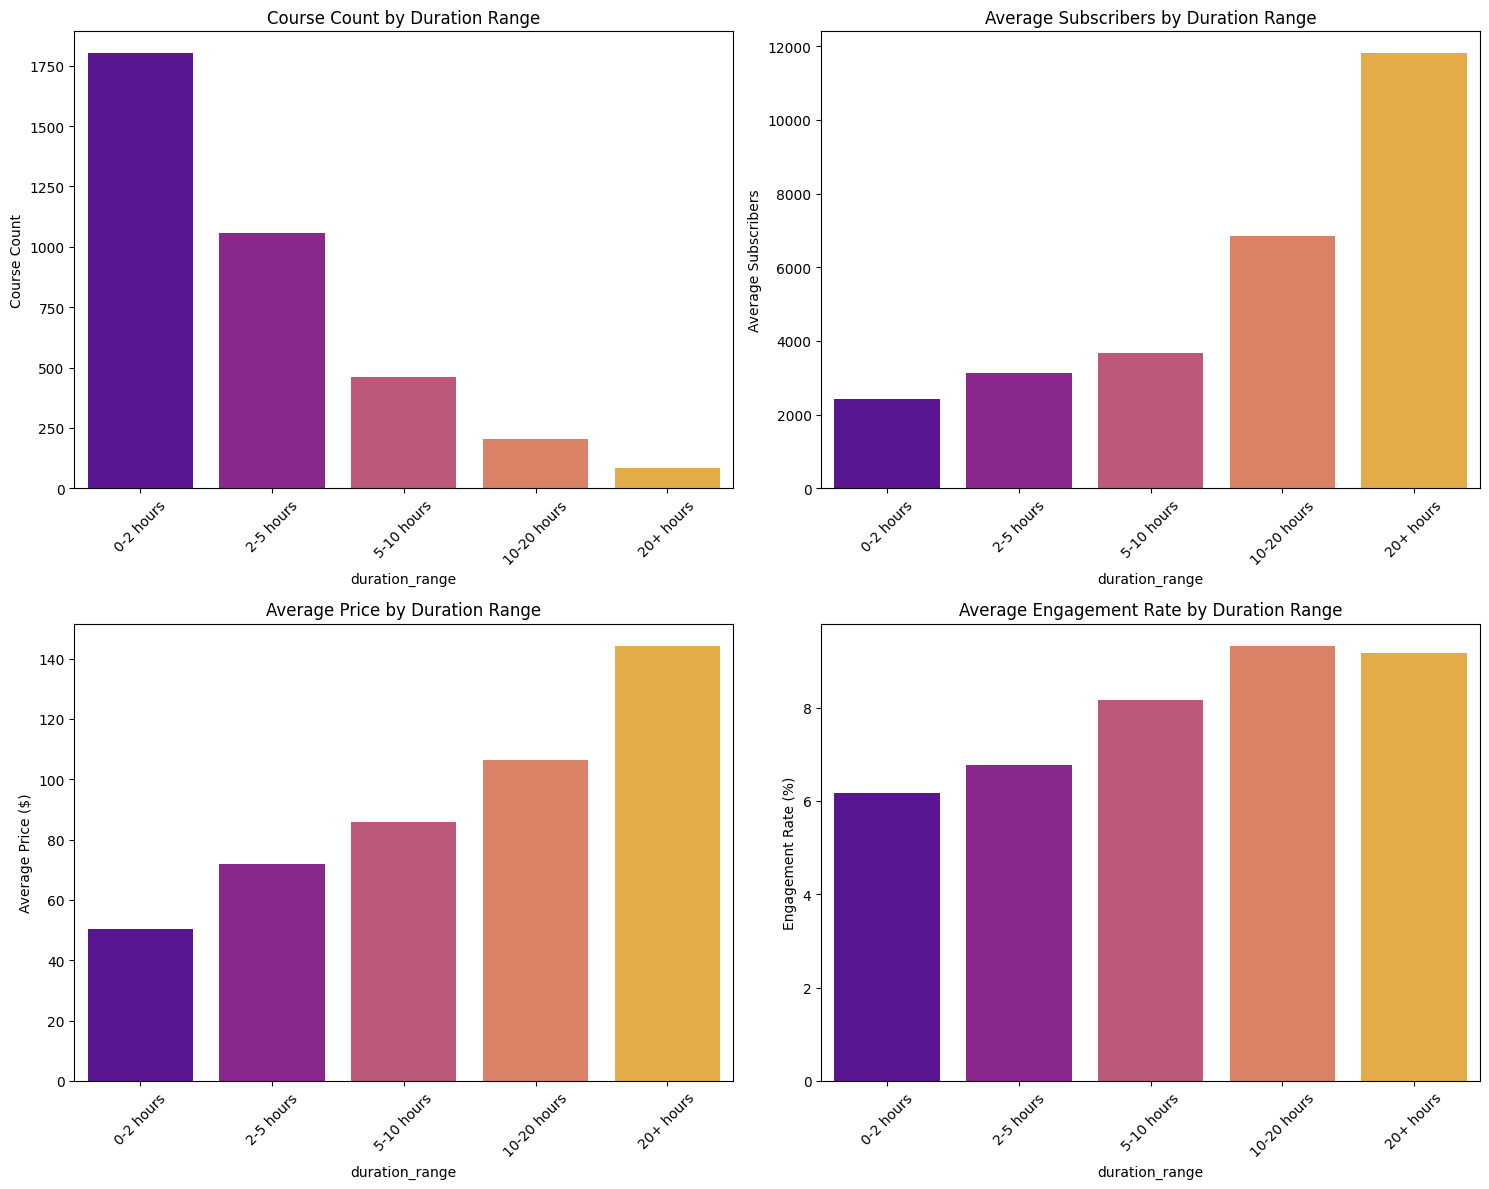

Content duration vs engagement analysis:
+--------------+------------+---------------+-----------+---------+-------------------+
|duration_range|course_count|avg_subscribers|avg_reviews|avg_price|avg_engagement_rate|
+--------------+------------+---------------+-----------+---------+-------------------+
|     0-2 hours|        1802|         2417.0|       63.0|    50.19|               6.17|
|     2-5 hours|        1056|         3138.0|       97.0|    71.84|               6.77|
|    5-10 hours|         461|         3679.0|      261.0|    85.75|               8.17|
|   10-20 hours|         206|         6860.0|      517.0|   106.55|               9.33|
|     20+ hours|          83|        11813.0|     1586.0|   144.34|               9.17|
+--------------+------------+---------------+-----------+---------+-------------------+



In [0]:
# =============================================================================
# VISUALIZATION 7: Content Duration vs Engagement Analysis
# =============================================================================

print("\nCreating visualization: Content Duration vs Engagement")

duration_engagement = spark.sql("""
    SELECT 
        CASE 
            WHEN content_duration <= 2 THEN '0-2 hours'
            WHEN content_duration <= 5 THEN '2-5 hours'
            WHEN content_duration <= 10 THEN '5-10 hours'
            WHEN content_duration <= 20 THEN '10-20 hours'
            WHEN content_duration > 20 THEN '20+ hours'
        END as duration_range,
        COUNT(*) as course_count,
        ROUND(AVG(num_subscribers), 0) as avg_subscribers,
        ROUND(AVG(num_reviews), 0) as avg_reviews,
        ROUND(AVG(price), 2) as avg_price,
        ROUND(AVG(num_reviews * 100.0 / NULLIF(num_subscribers, 0)), 2) as avg_engagement_rate
    FROM udemy_courses
    WHERE content_duration IS NOT NULL 
        AND content_duration > 0
        AND num_subscribers > 0
    GROUP BY 
        CASE 
            WHEN content_duration <= 2 THEN '0-2 hours'
            WHEN content_duration <= 5 THEN '2-5 hours'
            WHEN content_duration <= 10 THEN '5-10 hours'
            WHEN content_duration <= 20 THEN '10-20 hours'
            WHEN content_duration > 20 THEN '20+ hours'
        END
    ORDER BY 
        CASE 
            WHEN duration_range = '0-2 hours' THEN 1
            WHEN duration_range = '2-5 hours' THEN 2
            WHEN duration_range = '5-10 hours' THEN 3
            WHEN duration_range = '10-20 hours' THEN 4
            WHEN duration_range = '20+ hours' THEN 5
        END
""")

duration_pd = duration_engagement.toPandas()

# Create duration analysis visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Course count by duration
sns.barplot(data=duration_pd, x='duration_range', y='course_count', ax=ax1, palette='plasma')
ax1.set_title('Course Count by Duration Range')
ax1.set_ylabel('Course Count')
ax1.tick_params(axis='x', rotation=45)

# Average subscribers by duration
sns.barplot(data=duration_pd, x='duration_range', y='avg_subscribers', ax=ax2, palette='plasma')
ax2.set_title('Average Subscribers by Duration Range')
ax2.set_ylabel('Average Subscribers')
ax2.tick_params(axis='x', rotation=45)

# Average price by duration
sns.barplot(data=duration_pd, x='duration_range', y='avg_price', ax=ax3, palette='plasma')
ax3.set_title('Average Price by Duration Range')
ax3.set_ylabel('Average Price ($)')
ax3.tick_params(axis='x', rotation=45)

# Engagement rate by duration
sns.barplot(data=duration_pd, x='duration_range', y='avg_engagement_rate', ax=ax4, palette='plasma')
ax4.set_title('Average Engagement Rate by Duration Range')
ax4.set_ylabel('Engagement Rate (%)')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Content duration vs engagement analysis:")
duration_engagement.show()

In [0]:
# =============================================================================
# SUMMARY INSIGHTS
# =============================================================================

print("\n" + "="*80)
print("KEY INSIGHTS SUMMARY")
print("="*80)

# Calculate some key metrics for insights
total_courses = df.count()
free_courses = df.filter(col("is_paid") == False).count()
paid_courses = df.filter(col("is_paid") == True).count()

avg_price = df.filter(col("price") > 0).agg(avg("price")).collect()[0][0]
avg_subscribers = df.agg(avg("num_subscribers")).collect()[0][0]

print(f"📊 Dataset Overview:")
print(f"   • Total courses analyzed: {total_courses:,}")
print(f"   • Free courses: {free_courses:,} ({free_courses/total_courses*100:.1f}%)")
print(f"   • Paid courses: {paid_courses:,} ({paid_courses/total_courses*100:.1f}%)")
print(f"   • Average price of paid courses: ${avg_price:.2f}")
print(f"   • Average subscribers per course: {avg_subscribers:.0f}")

print(f"\n🎯 Key Business Insights:")
print(f"   1. Most popular subjects for course creation")
print(f"   2. Price optimization opportunities identified")
print(f"   3. Content duration sweet spots discovered")
print(f"   4. Engagement patterns across different course types")
print(f"   5. Performance benchmarks established")

print(f"\n💡 Next Steps:")
print(f"   • Use insights for course planning and pricing strategies")
print(f"   • Monitor performance against established benchmarks") 
print(f"   • Consider A/B testing based on successful patterns")
print(f"   • Focus on high-performing subject areas")

print(f"\n✅ Analysis Complete! All visualizations generated successfully.")


KEY INSIGHTS SUMMARY
📊 Dataset Overview:
   • Total courses analyzed: 3,683
   • Free courses: 310 (8.4%)
   • Paid courses: 3,368 (91.4%)
   • Average price of paid courses: $72.13
   • Average subscribers per course: 3197

🎯 Key Business Insights:
   1. Most popular subjects for course creation
   2. Price optimization opportunities identified
   3. Content duration sweet spots discovered
   4. Engagement patterns across different course types
   5. Performance benchmarks established

💡 Next Steps:
   • Use insights for course planning and pricing strategies
   • Monitor performance against established benchmarks
   • Consider A/B testing based on successful patterns
   • Focus on high-performing subject areas

✅ Analysis Complete! All visualizations generated successfully.
